In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
from scipy.stats import norm

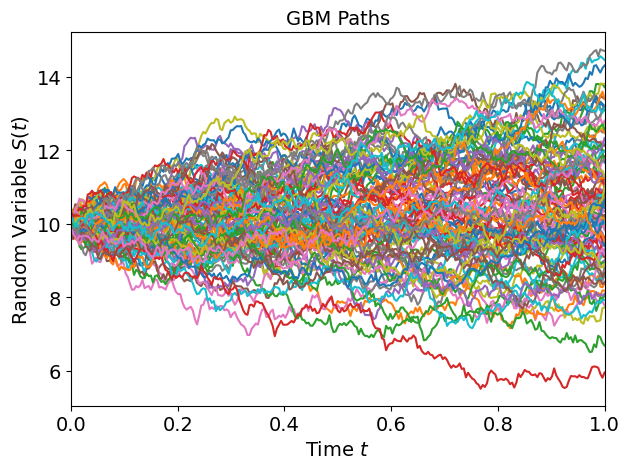

In [2]:
fig = plt.figure()

T = 1  # years
N = 255  # Number of points, number of subintervals = N-1
dt = T / N  # Time step in "years"
t = np.linspace(0, T, N)
M = 100  # Number of paths (Monte Carlo approach)
vol = 0.18
S0 = 10
mu = 0.08  # drift

dS = S0 * (mu * dt + vol * np.sqrt(dt) * np.random.randn(M, N)) # this is wrong as we are multiplyin with S0 even the increment on the later stages, ideally we should do it simulataneously
S = S0 + np.cumsum(dS, axis=1)


for i in range(M):
    plt.plot(t, S[i, :])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("Random Variable $S(t)$", fontsize=14)
plt.title("GBM Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

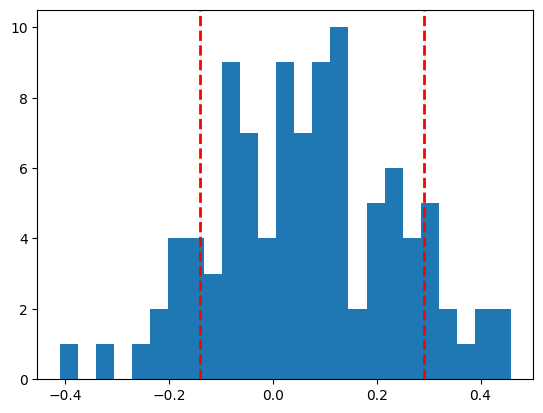

In [3]:
Returns = (S[:, -1] - S[:, 0]) / S[:, 0]
plt.hist(Returns, bins=25)

plt.axvline(np.percentile(Returns, 10), color="r", linestyle="dashed", linewidth=2)
plt.axvline(np.percentile(Returns, 90), color="r", linestyle="dashed", linewidth=2)

plt.show()

In [4]:
def bs_call_price(S, r, sigma, t, T, K):
    ttm = T - t

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        return np.maximum(S - K, 0.0)

    vol = sigma * np.sqrt(ttm)

    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol

    d_plus = d_minus + vol

    res = S * norm.cdf(d_plus)
    res -= K * np.exp(-r * ttm) * norm.cdf(d_minus)

    return res

In [5]:
def bs_put_price(S, r, sigma, t, T, K):
    ttm = T - t

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        return np.maximum(K - S, 0.0)

    vol = sigma * np.sqrt(ttm)

    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol

    d_plus = d_minus + vol

    res = S * norm.cdf(-d_plus)
    res = K * np.exp(-r * ttm) * norm.cdf(-d_minus) - res

    return res

## Computing Greeks

In [46]:
import numpy as np
import scipy.stats as ss

# Data for input in Black-Scholes formula:

T = 0.25  # supposed in years. It is not the maturity, but the time to maturity
S = 62.5
K = 55.0
r = 0.0325
vol = 0.55  # supposing it is annual
option_type = "C"  # for the put insert 'P'
# dividend yield assumed to be 0

# Compute d1 and d2
d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
d2 = d1 - vol * np.sqrt(T)

if option_type in ["C", "P"]:
    if option_type in ["C"]:
        Opt_Price = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
        Delta = ss.norm.cdf(d1)
        Gamma = ss.norm.pdf(d1) / (S * vol * np.sqrt(T))
        Vega = S * ss.norm.pdf(d1) * np.sqrt(T)
        Theta = -(S * ss.norm.pdf(d1) * vol) / (2 * np.sqrt(T)) - r * K * np.exp(
            -r * T
        ) * ss.norm.cdf(d2)
        Rho = K * T * np.exp(-r * T) * ss.norm.cdf(d2)
    else:
        Opt_Price = K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)
        Delta = -ss.norm.cdf(-d1)
        Gamma = ss.norm.pdf(d1) / (S * vol * np.sqrt(T))
        Vega = S * ss.norm.pdf(d1) * np.sqrt(T)
        Theta = -(S * ss.norm.pdf(d1) * vol) / (2 * np.sqrt(T)) + r * K * np.exp(
            -r * T
        ) * ss.norm.cdf(-d2)
        Rho = -K * T * np.exp(-r * T) * ss.norm.cdf(-d2)
else:
    Opt_Price = "Error: option type incorrect. Choose P for a put option or C for a call option."

print("Option price = {}".format(Opt_Price))
print("Delta = {}".format(Delta))
print("Gamma = {}".format(Gamma))
print("Vega = {}".format(Vega))
print("Theta = {}".format(Theta))
print("Rho = {}".format(Rho))

Option price = 11.13378307935897
Delta = 0.7362719534232142
Gamma = 0.019010459112384977
Vega = 10.21069581231615
Theta = -12.365469848859503
Rho = 8.72080350239798


##  Monte-carlo Methods pricing comparision with Black scholes method (Analytical)

In [29]:
np.random.seed(1)
r = 0.1
sigma = 0.2
T = 1.0
S0 = 100

Ite = 1
M = 100000

dt = T / M

S = np.zeros((M + 1, Ite))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp(
        (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal(Ite)
    )

In [47]:
np.random.seed(2)
r = 0.08
sigma = 0.24
dt = 1 / 255
S2 = 48 * np.exp(
        (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal()
    )

In [49]:
S2

47.70986461793849

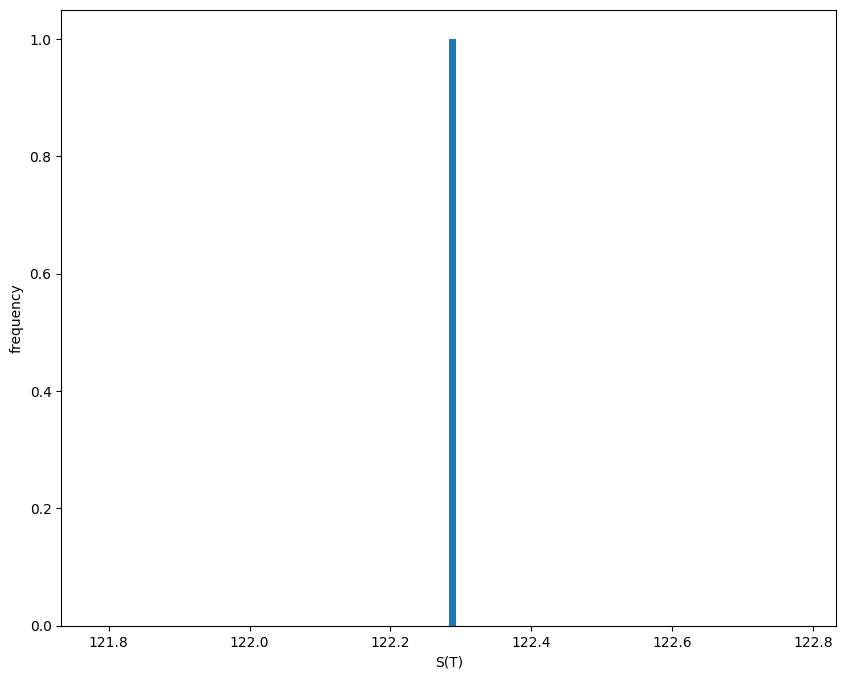

In [20]:
plt.figure(figsize=(10, 8))
plt.hist(S[-1], bins=100)
plt.xlabel("S(T)")
plt.ylabel("frequency")
plt.show()

In [21]:
def bs_call_monte_carlo(S, K, r, sigma, T, t, Ite):
    data = np.zeros((Ite, 2))
    z = np.random.normal(0, 1, [1, Ite])
    ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)
    data[:, 1] = ST - K

    average = np.sum(np.amax(data, axis=1)) / float(Ite)

    return np.exp(-r * (T - t)) * average

In [57]:
np.random.seed(2)
print("Monte Carlo Price:", bs_call_monte_carlo(32.5, 27.5, 0.0275, 0.45, 4/12, 0, 3000))

Monte Carlo Price: 4.595652436841063


In [34]:
np.random.seed(1)
z = np.random.normal(0, 1)
r = 0.1
sigma = 0.2
S = 100
T = 1
t = 0
ST = S * np.exp((T - t) * (r - 0.5 * sigma**2) + sigma * np.sqrt(T - t) * z)

In [35]:
ST

149.9106213327424

In [7]:
#bs_call_price(S, r, sigma, t, T, K)
bs_call_price(32.5, 0.0275, 0.45, 0, 4/12, 27.5)

6.391440240040197

In [50]:
np.random.seed(42)
bs_call_monte_carlo(38.75, 42, 0.01, 0.55, 5/12, 0, 4500)

4.268857657945811

In [53]:
x = 0.75*0.75*0.25*0.25 + 0.25*0.25*0.3*0.3

In [55]:
np.sqrt(x)

0.2019436802675439